Max Wang<br>
PHYS 434<br>
Lab 4<br>
Partner: Alexander Hyde

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from collections import Counter
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)
hf = h5py.File('E:/EECS/PHYS434/gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))
hf.close

<bound method File.close of <HDF5 file "gammaray_lab4.h5" (mode r)>>

## Problem 1

The data for the first problem comes from a gamma-ray satellite orbiting in low Earth orbit. The satellite detects particles every 100 milliseconds for 90 minutes. 

There are 4 columns of data: time in GPS seconds, particle counts and solar phase and Earth longtitude in degrees. Below are several plots exploring the data. 

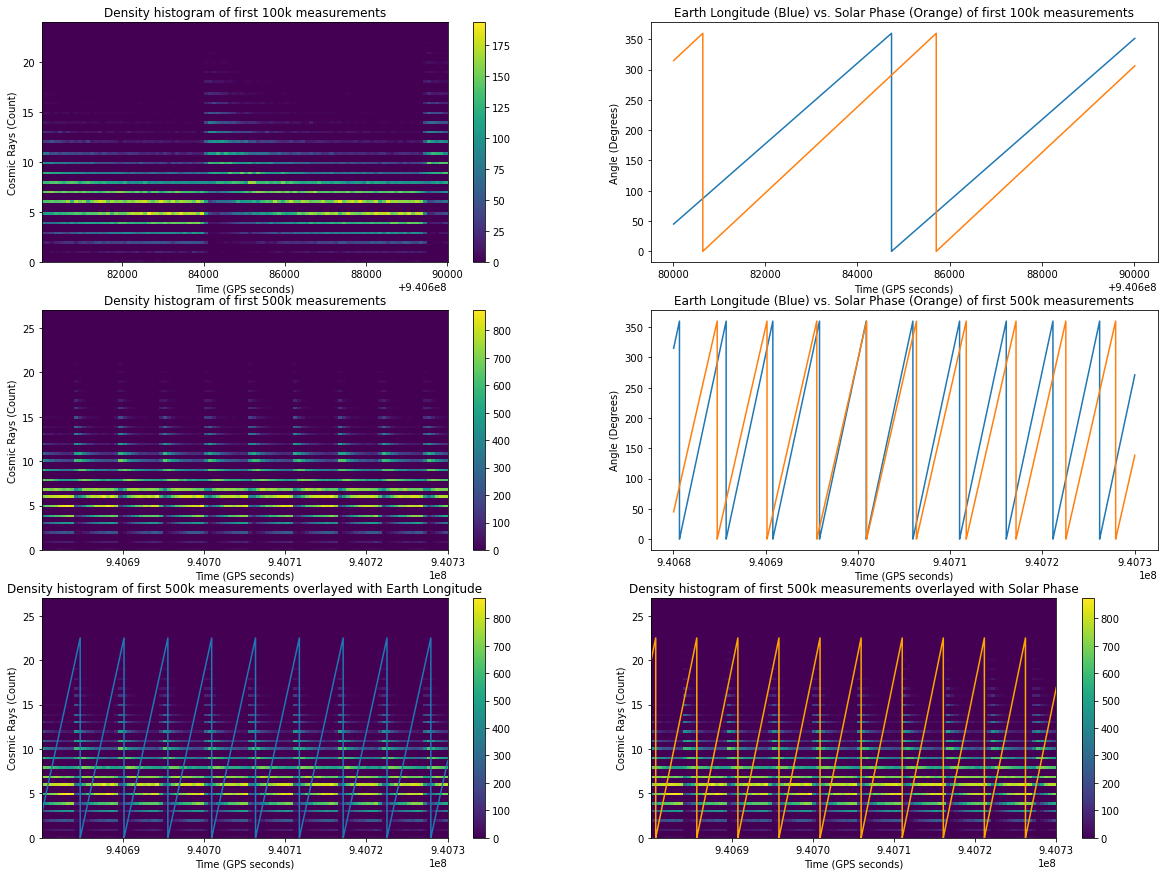

In [182]:
plt.subplots(3,2)
plt.subplot(3,2,1)
plt.title('Density histogram of first 100k measurements')
plt.hist2d(data[0,:100000], data[3,:100000],100)
plt.xlabel("Time (GPS seconds)")
plt.ylabel("Cosmic Rays (Count)")
plt.colorbar()
plt.subplot(3,2,2)
plt.title('Earth Longitude (Blue) vs. Solar Phase (Orange) of first 100k measurements')
plt.plot(data[0,:100000], data[2,:100000])
plt.plot(data[0,:100000], data[1,:100000])
plt.xlabel("Time (GPS seconds)")
plt.ylabel("Angle (Degrees)")
plt.subplot(3,2,3)
plt.title('Density histogram of first 500k measurements')
plt.hist2d(data[0,:500000], data[3,:500000],100)
plt.xlabel("Time (GPS seconds)")
plt.ylabel("Cosmic Rays (Count)")
plt.colorbar()
plt.subplot(3,2,4)
plt.title('Earth Longitude (Blue) vs. Solar Phase (Orange) of first 500k measurements')
plt.plot(data[0,:500000], data[1,:500000])
plt.plot(data[0,:500000], data[2,:500000])
plt.xlabel("Time (GPS seconds)")
plt.ylabel("Angle (Degrees)")
plt.subplot(3,2,5)
plt.title('Density histogram of first 500k measurements overlayed with Earth Longitude')
plt.hist2d(data[0,:500000], data[3,:500000],100)
plt.plot(data[0,:500000], data[2,:500000]/16)
plt.xlabel("Time (GPS seconds)")
plt.ylabel("Cosmic Rays (Count)")
plt.colorbar()
plt.subplot(3,2,6)
plt.title('Density histogram of first 500k measurements overlayed with Solar Phase')
plt.hist2d(data[0,:500000], data[3,:500000],100)
plt.plot(data[0,:500000], data[1,:500000]/16, color='orange')
plt.xlabel("Time (GPS seconds)")
plt.ylabel("Cosmic Rays (Count)")
plt.colorbar()
plt.show()

From the density plots, we can see that the particle count distribution doesn't stay constant with time, but repeats a certain periodic pattern. It could be that some celestial object is blocking parts of the sky where the cosmic rays are coming from, distrupting the otherwise smoother and constant distribution. The pattern starts with a sharp peak, then slowly declines. 

When overlapped with the Earth longtitude line, the period of the particle counts seems to align with it. However, there is some phase shift between the two. As for the solar phase, its period is longer than both the particle count pattern and the Earth longtitude, making it hard to correlate the solar phase with the rest of the other features. 

Below is time vs particle count of the first 100k measurements. The data is really messy, so I am going to try and smooth it out by averaging the data.

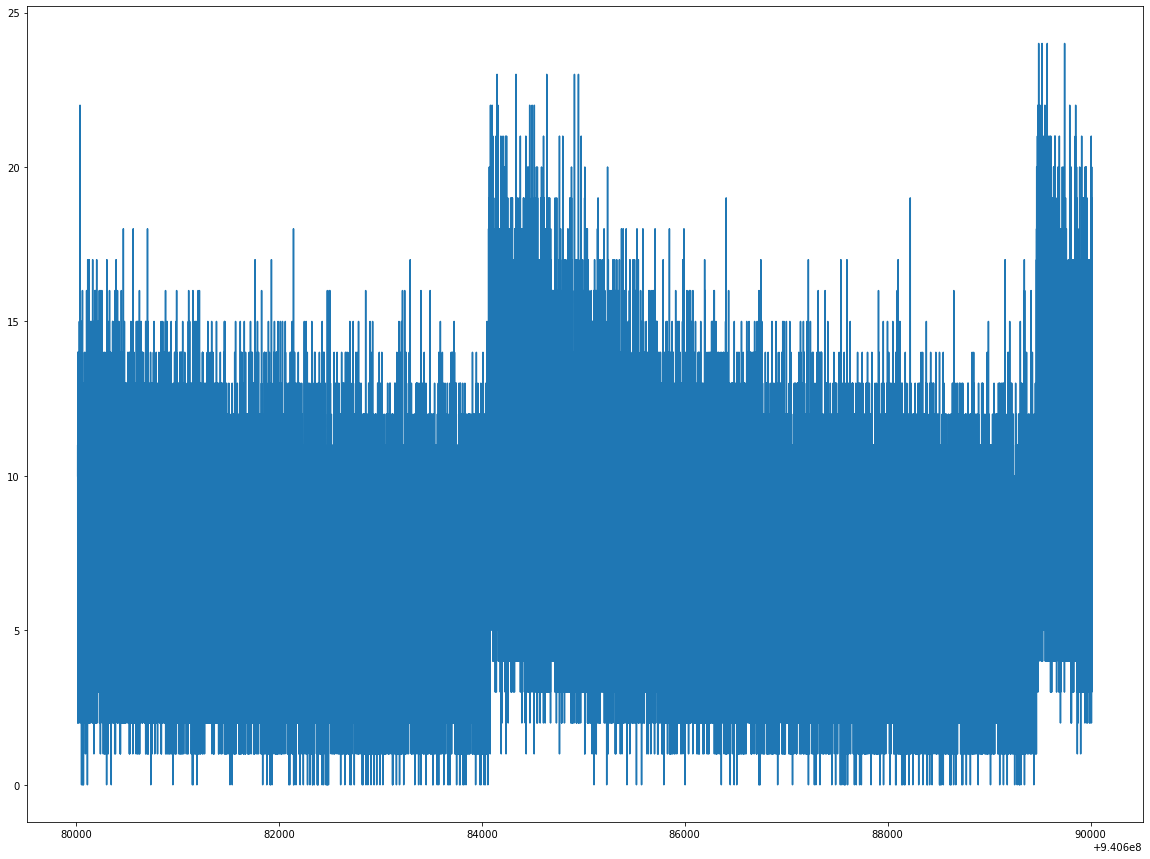

In [183]:
plt.plot(data[0,:100000], data[3,:100000])
plt.show()

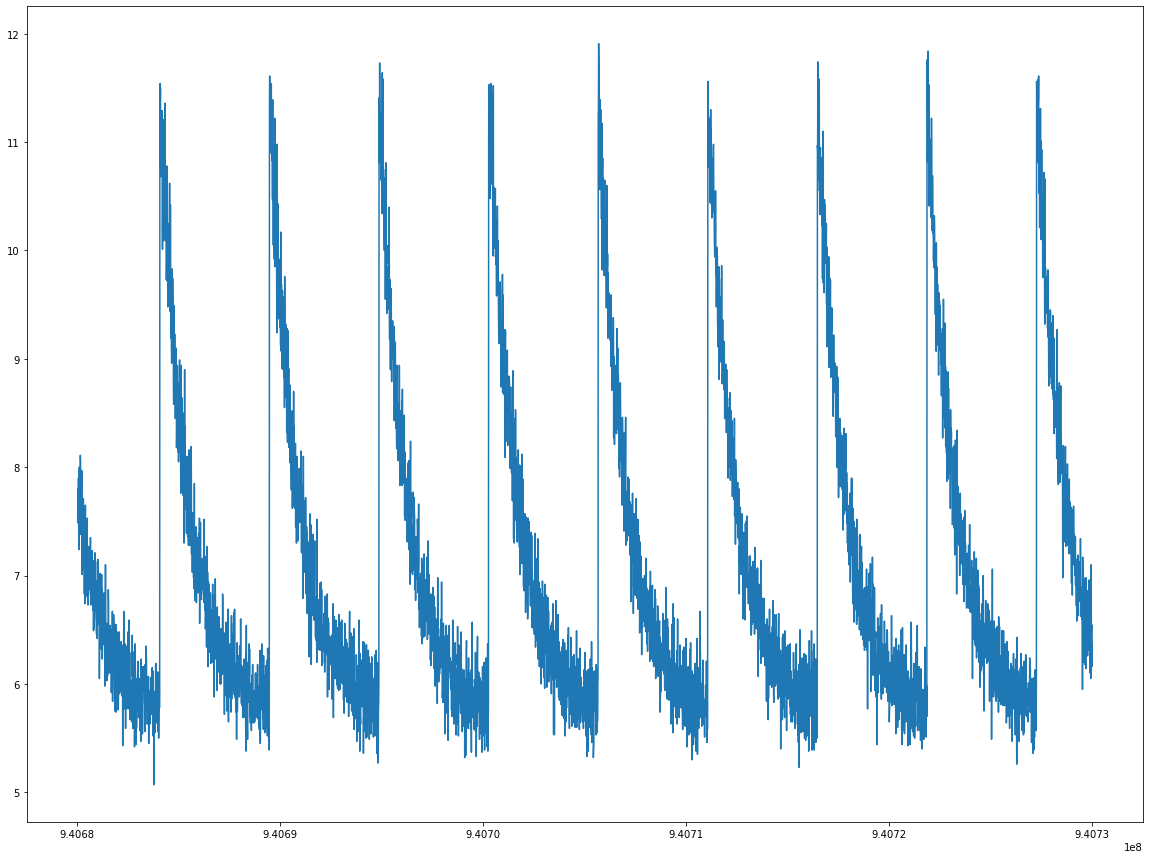

In [184]:
def avgPlot(start, end):
    avgDist = []
    newTime = []
    for i in range(start, end, 100):
        subset = data[3, i:i+100]
        avg = sum(subset)/100
        timeAvg = (data[0, i] + data[0, i+100])/2
        avgDist.append(avg)
        newTime.append(timeAvg)
    return avgDist, newTime
dist, x = avgPlot(0, 500000)
plt.plot(x[0:], dist)
plt.show()

Above is my attempt at smoothing the data out, averaging every 100 GPS second intervals. The data is much smoother now, and because of the repeating pattern is much more recognizable now, I am going to try and fold the data by the average peak to peak time <code>ppAvg</code>. However, I feel like this clipped data before the first peak might weird my model. To make a sloping downward model from start to end, I am going offset the distribution by the time of the occurance of the first peak.

In [185]:
ppTime = []
for i in range(len(dist) - 1):
    diff = dist[i+1] - dist[i]
    if diff > 4:
        ppTime.append(x[i+1])

ppAvg = np.mean(np.diff(ppTime))
offset = x[np.where(x==ppTime[0])[0][0]] - data[0, 0]

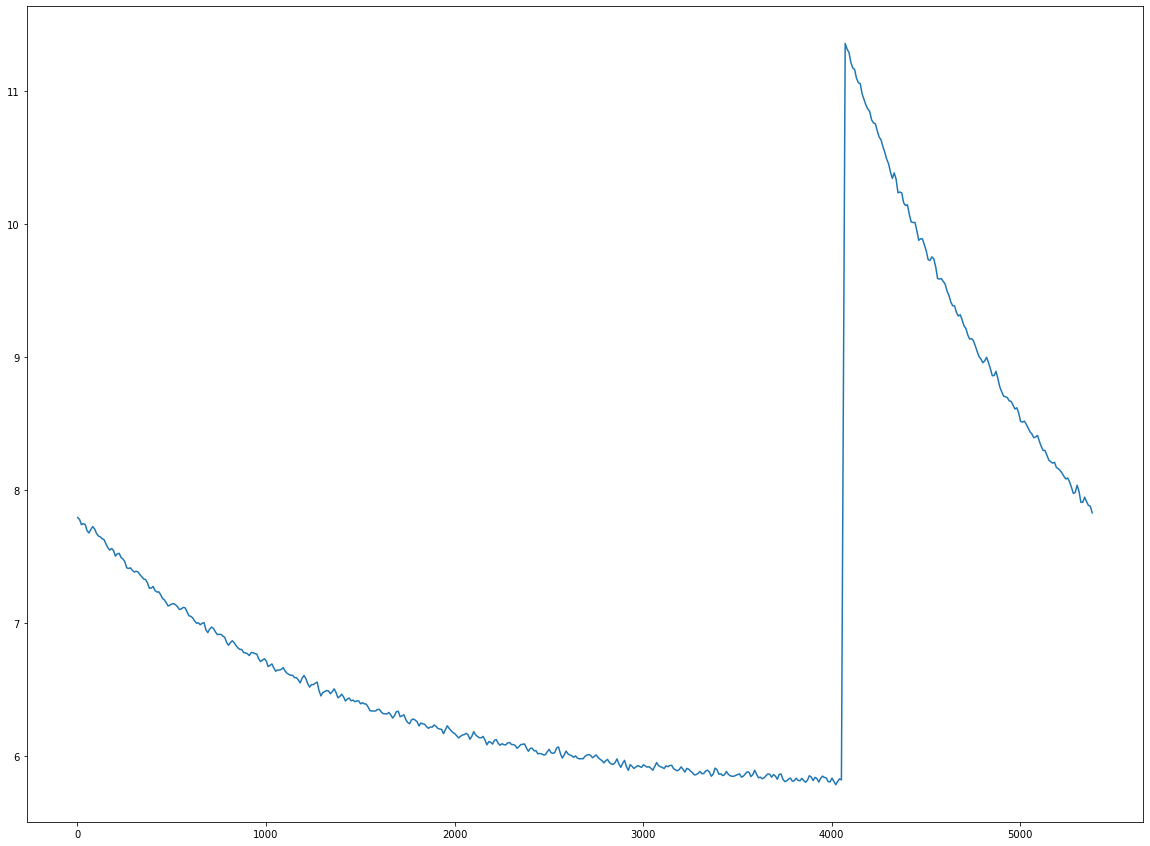

In [187]:
dist, x = avgPlot(0, 5000000)
x = x%ppAvg
new_dist = []
new_x = [*range(1, int(max(x)), 10)]
for i in new_x:
    temp = []
    for j in range(len(x)):
        if x[j] == i or x[j] == (i+10):
            temp.append(dist[j])
    new_dist.append(sum(temp)/len(temp))
plt.plot(new_x, new_dist)
plt.show()

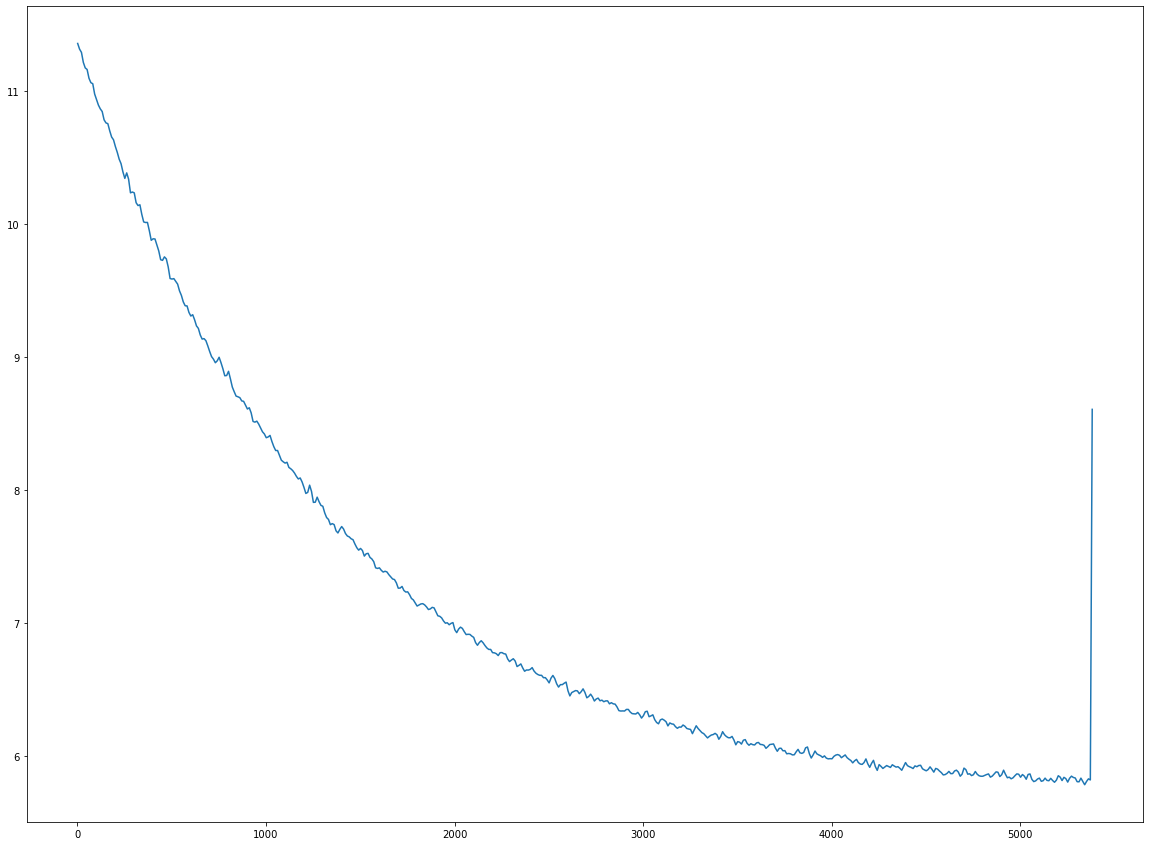

In [188]:
peakT = 0
for i in range(len(new_dist)):
    if new_dist[i] > 11:
        peakT = i
        break
sorted_dist = new_dist[peakT:]
sorted_dist.extend(new_dist[0:peakT])
plt.plot(new_x, sorted_dist)
plt.show()

After I folded my model by <code>ppAvg</code>, I averaged my data again to smooth it out further. Now we can see a nice down slope curve from beginning to end. Initially my model had the peak in the middle as I suspected, and I manually shifted my model distribution to account for the offset. Before I am going to test my model, I should test how my background PDF should be represented. We've been working with cosmic rays for quite a while now, and because the particle counts are discrete, I am going to try and see if it can be represented by a Poisson PDF. Now I am going to test my model by inputting an actual recorded time and comparing the result average cosmic ray count with one obtained with a Poisson distribution. Before fitting the input into my model, I am going to offset the time by the first peak and folding it as well.

<function matplotlib.pyplot.show(close=None, block=None)>

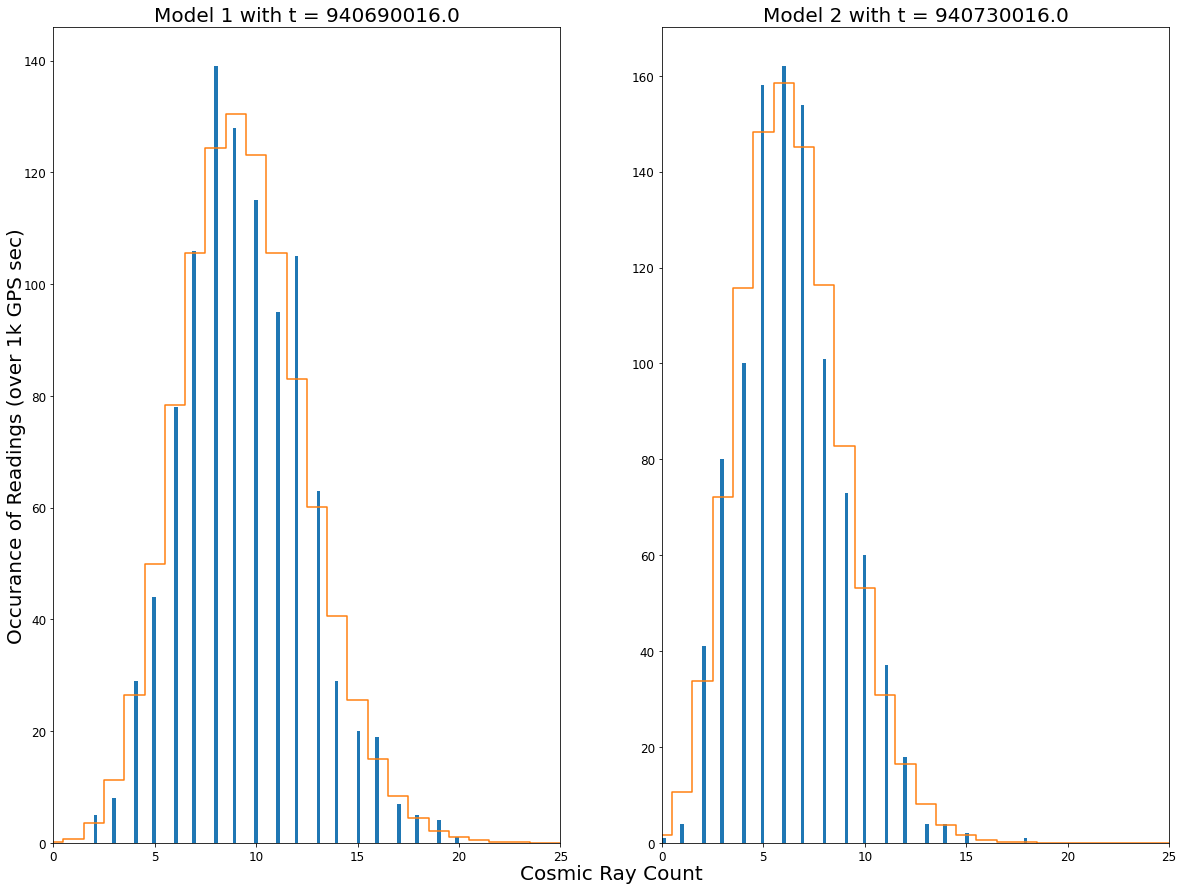

In [189]:
fig, ax = plt.subplots(1,2)

x = np.linspace(0, 25, 26)
plt.subplot(1,2,1)
plt.tick_params(labelsize = 12)
subdata = data[3,100000:101000]
avg1 = sum(subdata)/len(subdata)
plt.title('Model 1 with t = ' + str(data[0, 100000]),size = 20)
plt.xlim(0,25)
plt.hist(subdata, 100)
plt.step(x, stats.poisson.pmf(x, avg1)*1000, where='mid')
plt.subplot(1,2,2)
plt.tick_params(labelsize = 12)
subdata = data[3,500000:501000]
avg2 = sum(subdata)/len(subdata)
plt.title('Model 2 with t = ' + str(data[0, 500000]),size = 20)
plt.xlim(0,25)
plt.hist(subdata, 100)
plt.step(x, stats.poisson.pmf(x, avg2)*1000, where='mid')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Cosmic Ray Count',size = 20)
plt.ylabel('Occurance of Readings (over 1k GPS sec)',size = 20)
plt.show

In [190]:
def modelFit(gps):
    folded = int((gps-offset)%ppAvg)
    for i in range(len(new_x)):
        if new_x[i] == folded:
            return sorted_dist[i]
        elif folded - new_x[i] < 10:
            avgTick = (sorted_dist[i+1] - sorted_dist[i])/10
            return sorted_dist[i] + (avgTick * (folded - new_x[i]))


print('For model 1, my Poisson average was ' + str(avg1) + ', and my model average was ' + str(modelFit(data[0,100000])))
print('For model 2, my Poisson average was ' + str(avg2) + ', and my model average was ' + str(modelFit(data[0,500000])))

For model 1, my Poisson average was 9.433, and my model average was 9.416467391304348
For model 2, my Poisson average was 6.41, and my model average was 6.437419354838711


I fitted two different t values to my model(at t = 100000, 500000), and then plotted the model with the equivalent Poisson distribution overlayed(orange). I also compared the model and Poisson averages for the two t values. The model seems to fit pretty well, looking at the plot as well as how close the averages are.

In [192]:
sigma5 = stats.norm.cdf(5,0,1)
test_t = [324115, 525362, 2151612, 5689321, 97546]
for i in range(5):
    t = data[0,test_t[i]]
    print('At t = ' + str(test_t[i]) + ', the 5-sigma value is ' + str(stats.poisson.ppf(sigma5,modelFit(t))))

At t = 324115, the 5-sigma value is 25.0
At t = 525362, the 5-sigma value is 21.0
At t = 2151612, the 5-sigma value is 29.0
At t = 5689321, the 5-sigma value is 22.0
At t = 97546, the 5-sigma value is 30.0


Lastly, using my model I looked at the 5-sigma thresholds are random times in the data set.

## Problem 2

We will now analyze a set of 10 telescope images of the same sky at different times. Whereas my partner will be for a transient, I will instead find the faintest star in this patch of sky. First, looking at the data, it seemed a bit out of order, so I rearranged it into a 10x200x200 3D array. To visualize the data, I showcased 4 different images in the form of a 2D histogram with color bar attached. The higher up in the color bar, the higher the brightness of the pixel.

In [3]:
hf2 = h5py.File('E:/EECS/PHYS434/images.h5', 'r')
imagestack = np.array(hf2.get('imagestack'))
hf.close()

In [4]:
images = np.zeros((10, 200, 200))
for i in range(10):
    for j in range(200):
        for k in range(200):
            images[i][j][k] = imagestack[j][k][i]

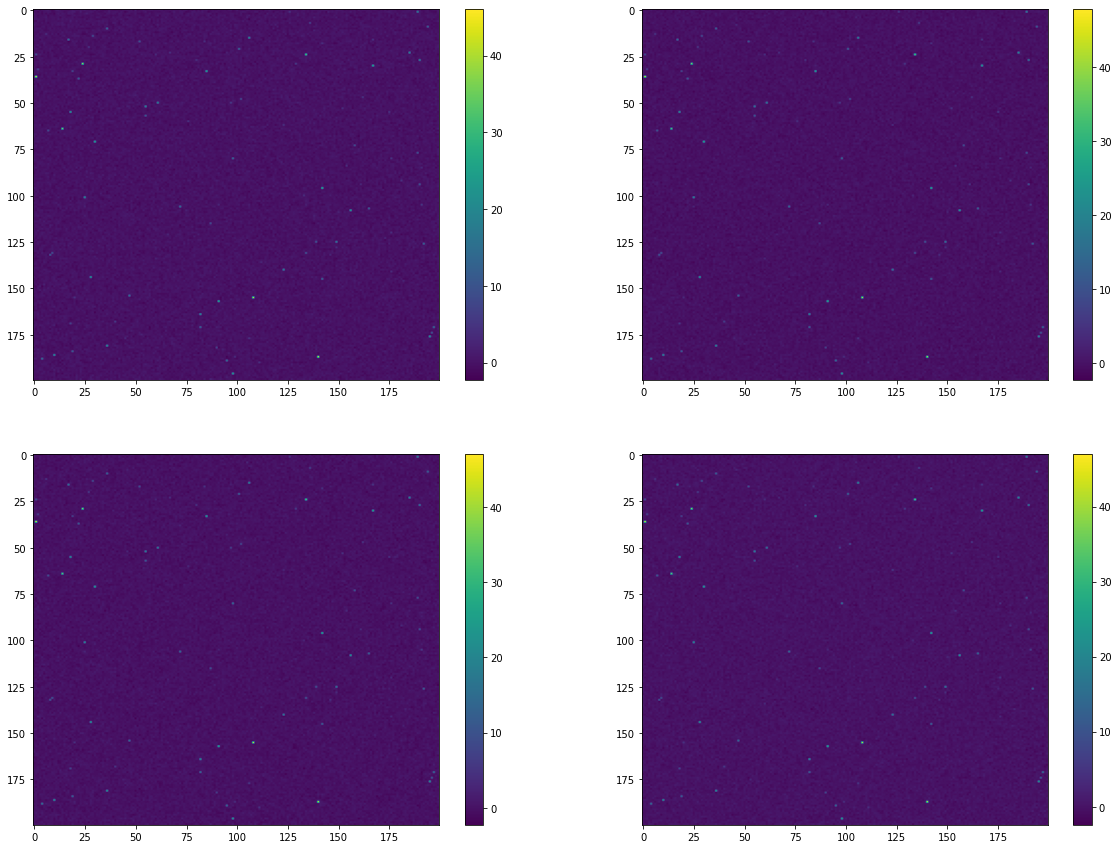

In [5]:
plt.subplots(2,2)
for i in range(4): 
    plt.subplot(2,2,i+1)
    plt.imshow(images[0+(i*2)],aspect='auto')
    plt.colorbar()
plt.show()

Now I want to try and make a background PDF. I will start by consolidating data points from all images into a 1D array and see if I can discover any pattern from the distribution.

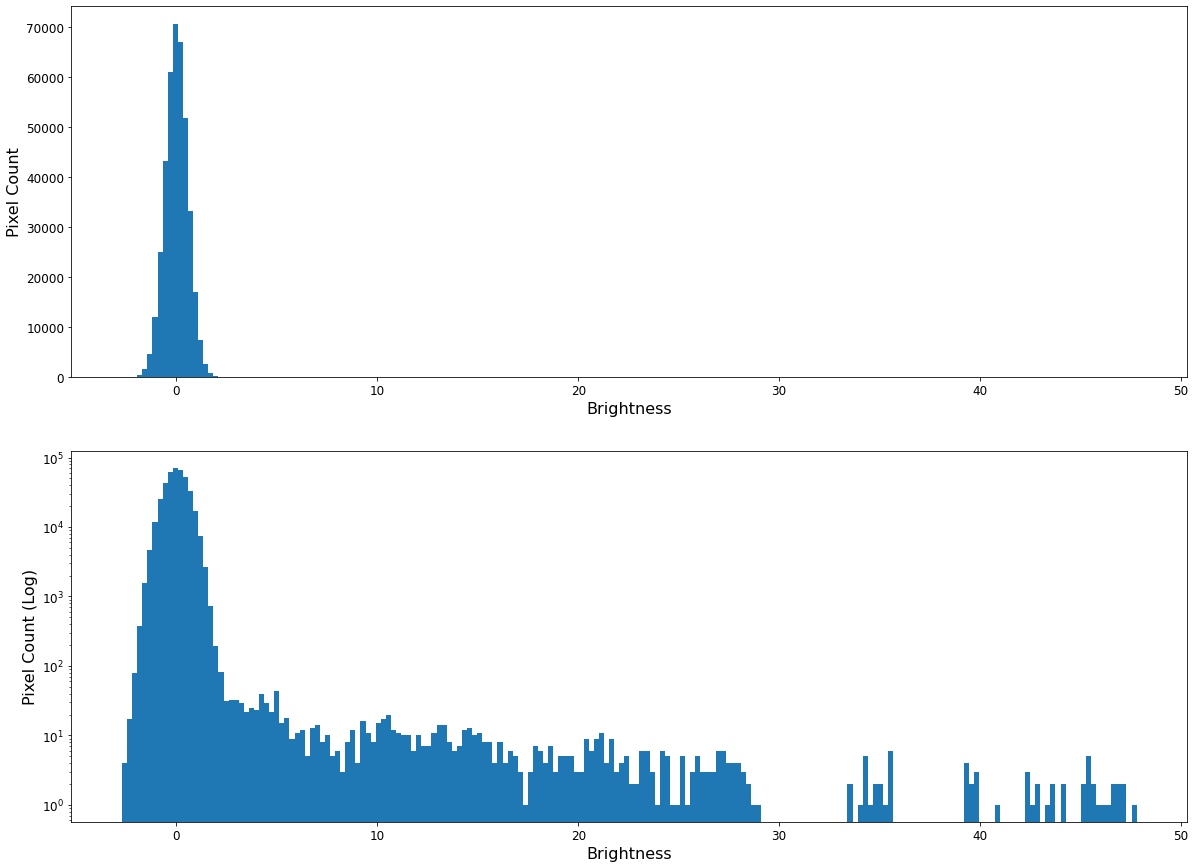

In [81]:
dist = images.reshape((400000,))
plt.subplots(2,1)
plt.subplot(2,1,1)
plt.hist(dist,200)
plt.xlabel("Brightness",fontsize=16)
plt.ylabel("Pixel Count",fontsize=16)
plt.tick_params(labelsize = 12)
plt.subplot(2,1,2)
plt.hist(dist,200)
plt.xlabel("Brightness",fontsize=16)
plt.ylabel("Pixel Count (Log)",fontsize=16)
plt.tick_params(labelsize = 12)
plt.yscale("log")
plt.show()

It wasn't too obvious from the first histogram, but after implementing a log scale we can clearly see a smooth Gaussian-like curve in the beginning of the distribution. I am going to try and fit a Gaussian distribution over this part.

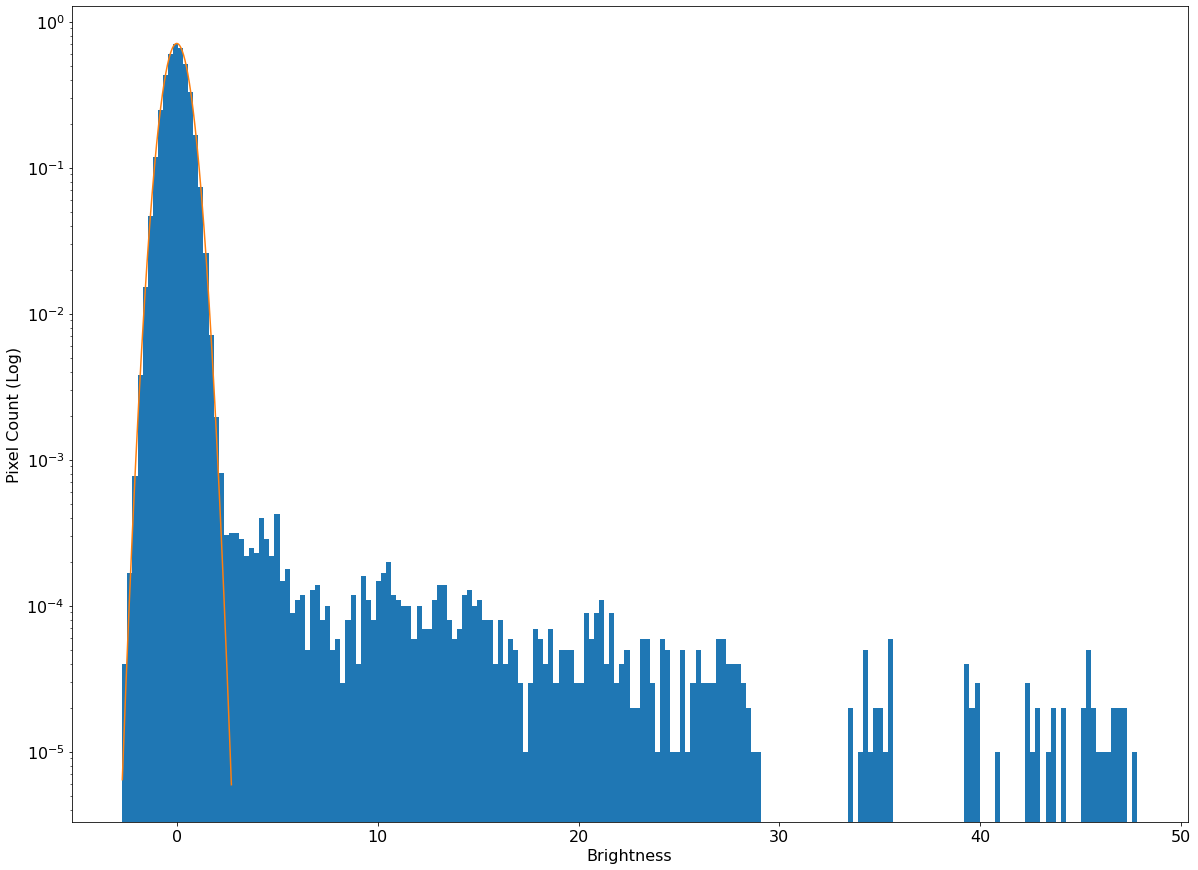

My Gaussian fit has a mean of 0.000868965108335211 and StD of 0.5624205398635362


In [172]:
normalDist = []
for i in dist:
    normalDist.append(i)
    if i > -(dist[0]):
        break
x = np.linspace(min(normalDist),max(normalDist),1000)
avg = np.mean(normalDist)
std = np.std(normalDist)
sig5 = stats.norm.ppf(1-(1-stats.norm.cdf(5,avg,std)),0,1)
plt.hist(dist,200,density=True)
plt.plot(x,stats.norm.pdf(x,avg,std))
plt.tick_params(labelsize = 16)
plt.xlabel("Brightness",fontsize=16)
plt.ylabel("Pixel Count (Log)",fontsize=16)
plt.yscale("log")
plt.show()
print("My Gaussian fit has a mean of " + str(avg) + " and StD of " + str(std))

The Guassian model seems to fit pretty well, so I will be using this as my background PDF. Any data points that are at or above the 5-sigma threshold of this PDF I will consider the pixel to be significant enough to be a star.

In [160]:
stars = []
for i in range(10):
    temp = []
    for j in range(200):
        for k in range(200):
            imgProb = (1 - stats.norm.cdf(images[i][j][k],avg,std))*40000
            sigma = stats.norm.ppf(1-imgProb,0,1)
            if sigma >= 5:
                temp.append((j,k))
    stars.append(temp)

Now that I've isolated the stars of each image, I am going to cross reference between the 10 images and and see which pixel was above the 5-sigma threshold in all 10 images. This is to ensure that each star is significant enough in all 10 images. Then, out of those new stars, I will average the brightness across the 10 images and see which star has the smallest average brightness, which I will determine as the faintest star, and isolate it in various images.

In [179]:
stars_1D = stars[0] + stars[1] + stars[2] + stars[3] + stars[4] + stars[5] + stars[6] + stars[7] + stars[8] + stars[9]
stars_1D = Counter(stars_1D).items()
new_stars = []
for i in stars_1D:
    if i[1] == 10:
        new_stars.append(i[0])
faintest = 0
faintest_xy = 0
for i in new_stars:
    temp = 0
    for j in range(10):
        temp += images[j][i[0]][i[1]]
    temp = temp/10
    if faintest == 0 or faintest > temp:
        faintest = temp
        faintest_xy = i
print('The faintest star has a brightness of ' + str(faintest) + ', and it\'s coordinates are ' + str(faintest_xy))

The faintest star has a brightness of 4.4616877347724255, and it's coordinates are (27, 80)


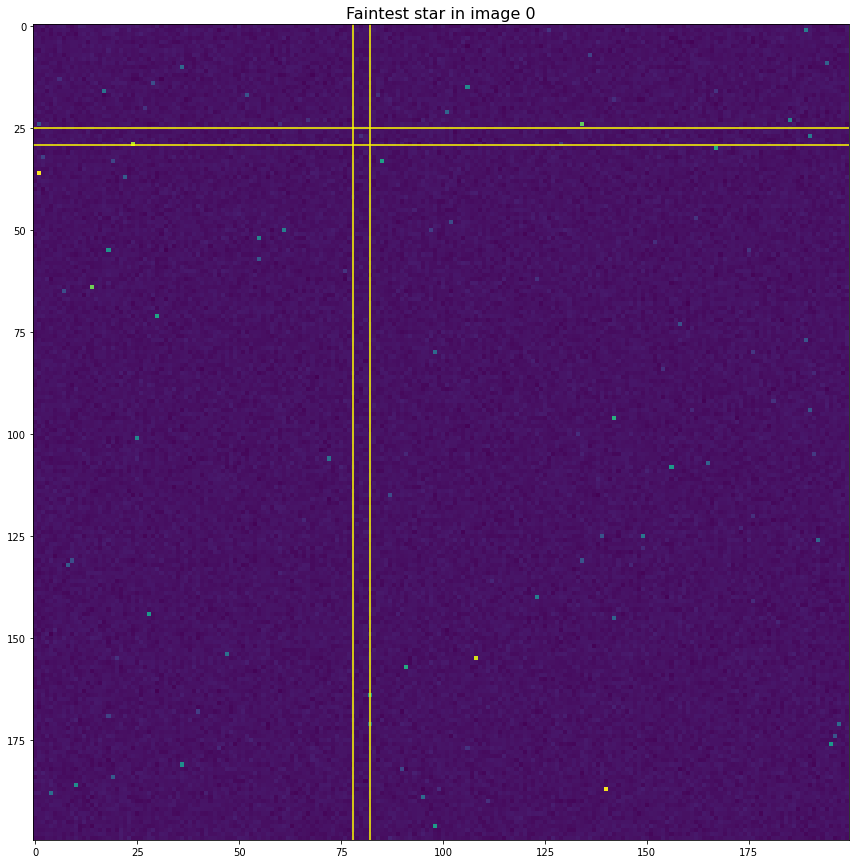

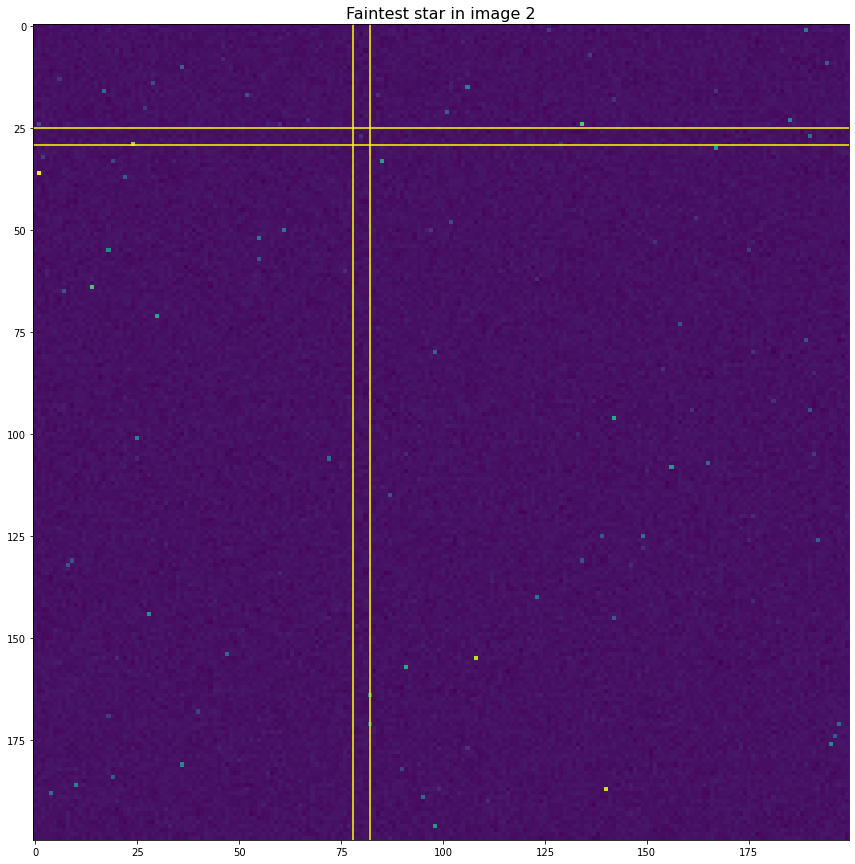

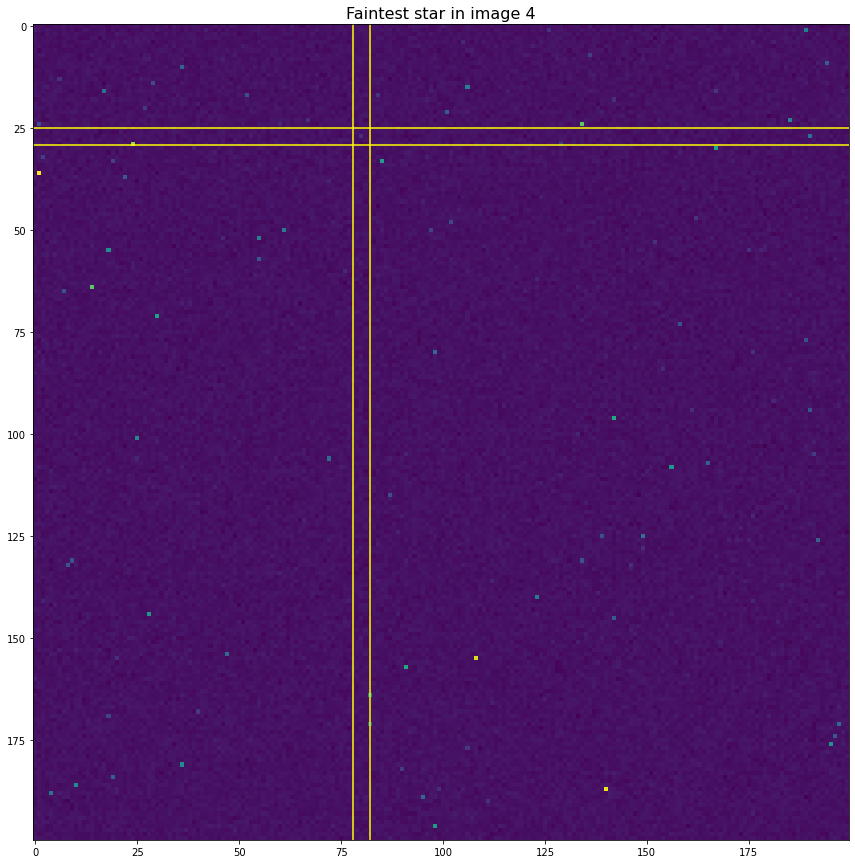

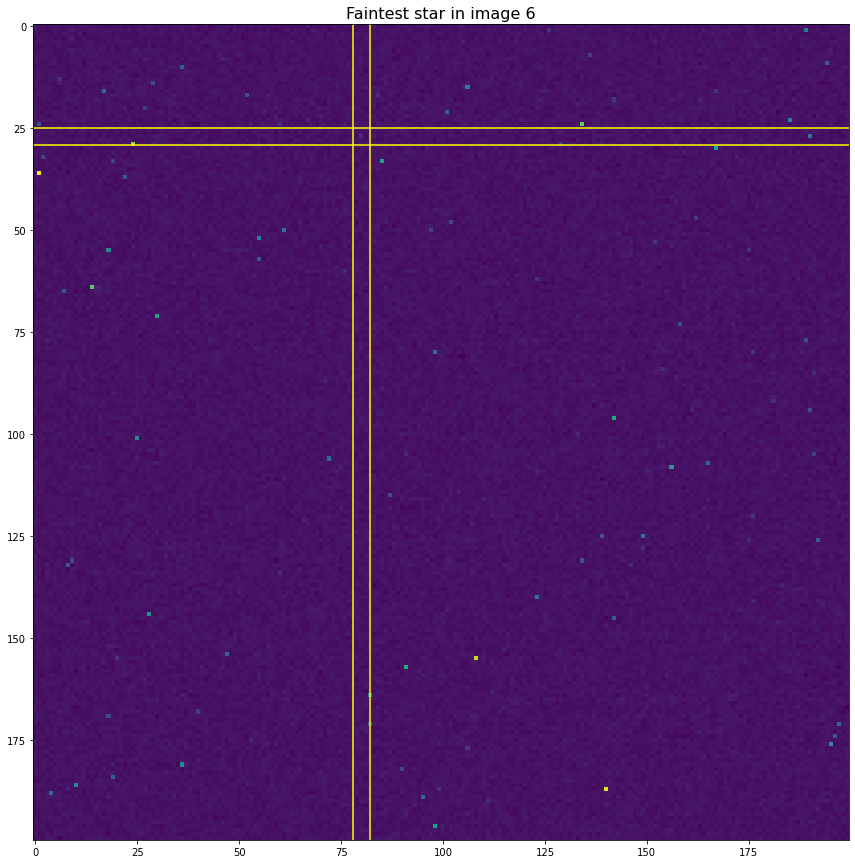

In [180]:
for i in range(4): 
    plt.title('Faintest star in image ' + str(i*2),fontsize=16)
    plt.imshow(images[0+(i*2)])
    plt.axhline(faintest_xy[0]+2,color='yellow')
    plt.axhline(faintest_xy[0]-2,color='yellow')
    plt.axvline(faintest_xy[1]+2,color='yellow')
    plt.axvline(faintest_xy[1]-2,color='yellow')
    plt.show()

In terms of having different PDFs between my partner and I, I think it is attributed to us having different objectives. A faint star will be present across the images, but a transient might only appear in a few. Of course, there could be multiple transient signals in different places as well. In my opinion, the PDF I got along with my approach can be replicated in trying to find a transient. But instead of finding signals present in all images, it would be more suitable to find the signals that appeared the least. Another approach would be making separate PDFs for each images and cross-reference the significant pixels that way. 